In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import os
import glob
import importlib
import multiprocessing as mp
import itertools
import math
import random 
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import scipy.spatial.distance as dist
from tqdm import tqdm
import pandas as pd
import tables
#import deepdish as dd

sys.path.append('/Users/johnmarshall/Documents/MATLAB/CNMF_E_jjm/python_wrapper/')
sys.path.append('/Users/johnmarshall/caiman_data/post_cnmfe_analysis')
import miniscope_analysis as ma 
import python_utils_jjm as utils_jjm
import jjm_post_cnmfe_fns as jjm
import align_msCam_tobehavior as align_tracking

from importlib import reload
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def plot_traces(neuron_idxs, frame_range, data_to_plot, normalize=True, fsize=(15,10)):
    """Inputs:
    neuron_idxs : list of neuron indicies to plot, e.g. range(1, 2) or [3, 50, 90]
    frame_range : tuple (start_frame, end_frame)
    data_to_plot : list of data to plot (e.g. ['C', 'C_raw'])        
    """
    plt.figure(figsize=fsize)
    plt.axis('on')
    arrays_to_plot = [np.array(results.cnmfe_results[data]) for data in data_to_plot]
    for idx in neurons_idx:
        for array in arrays_to_plot:
            if normalize==True:
                plt.plot(utils_jjm.normalize(array[idx, frame_range[0]:frame_range[1]]) + idx)
            else:
                plt.plot(array[idx, frames[0]:frames[1]] + idx)
    return()

In [4]:
results_file = r'C:\Users\Santiago PC\Documents\miniscope_data\GRIN_outputs\out\27-Feb_17_33_59\27-Feb_17_33_59_out.mat'
results = ma.miniscope_session(results_file)

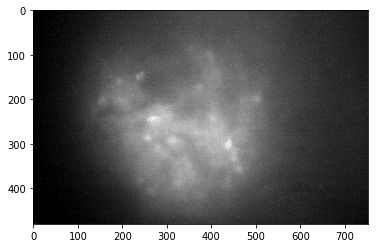

In [5]:
img_file = '/Users/Santiago PC/Documents/MiniscopeMovies/GRIN032/memmap_0000memmap_0023_resized_source_extraction_20-01-09.187/H17_M30_S22msCam2_f29.tif'
img_from_file = plt.imread(img_file)
plt.imshow(img_from_file, cmap='gray')

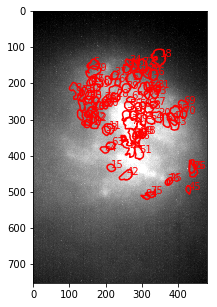

In [6]:
%matplotlib inline
neurons_idx = range(85)
plt.rcParams['figure.figsize'] = [5, 5]
coordinates = utils_jjm.plot_contours(results.cnmfe_results['A'].todense(), np.transpose(img_from_file), list_to_plot=neurons_idx, display_numbers=True, maxthr=.4,cmap='gray', colors='r')

In [7]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
def bin_correlation_rel_dist(results,frame_division,threshold,coordinates):
    """inputs:
    results : results.cnmfe_results.['C']
    frame_division : integer value used in frames at 20fps (e.g. 100 for 5 seconds)
    threshold : neuron amplitude usually around 0-5, 0.75 as threshold works well 
    coordinates: call it coordinates, output from plot.contours function, for relative_distance calculation using center of mass
    """
    threshold_list = []
    yes_no = []
    block_list = []
    block_nt_CC = []
    vid_length = len(results.transpose())
    CoM = []
    rel_dist = []
    z_score_list = []
    
    for neuron in coordinates:
        CoM.append(neuron['CoM'])
    for neuron1 in CoM:
        for neuron2 in CoM:
            if neuron1[0] != neuron2[0]:
                rel_dist.append(math.sqrt(((neuron1[0] - neuron2[0])**2) + ((neuron1[1] - neuron2[1])**2)))
    rel_dist_df = pd.DataFrame({"rel_dist": rel_dist})
    
    for neuron in results:
        z_score = stats.zscore(neuron)
        z_score_list.append(z_score)
    
    for neuron in z_score_list:
        for moment in neuron:
            if moment >= threshold:
                threshold_list.append(1)
            else:
                threshold_list.append(0)

    zero_one = np.asarray(list(chunks(threshold_list, frame_division)))
    for chunk in zero_one:
        if np.any(chunk > 0.50):
            yes_no.append('Yes')
        else:
            np.any(chunk <= 0.50)
            yes_no.append('No')
            
    for item in yes_no:
        if 'Yes' in item:
            block_list.extend([1] * frame_division)
        else:
            block_list.extend([0] * frame_division)
    block_neuron_list = (list(chunks(block_list, vid_length)))
    
    indicies = range(0,len(block_neuron_list))
    for neuron_1 in indicies:
        for neuron_2 in indicies:
            if neuron_1 != neuron_2:
                corrcoef = stats.pearsonr(block_neuron_list[neuron_1],block_neuron_list[neuron_2])
                block_nt_CC.append(corrcoef)
                
    block_CC_df = pd.DataFrame(block_nt_CC)
    block_CC_list_x = block_CC_df[0].values.tolist()
    block_CC_df_x = pd.DataFrame({"corrcoef":block_CC_list_x})
                                  
    dfs = [rel_dist_df, block_CC_df_x]
    combined_df = pd.concat(dfs, axis=1)
                                  
    return(combined_df, block_neuron_list, z_score_list,plt.scatter(rel_dist_df,block_CC_df[0]))


In [ ]:
#quick correlation view- frames 10 = half second
bin_correlation_rel_dist(results.cnmfe_results['C'],10,6,coordinates)

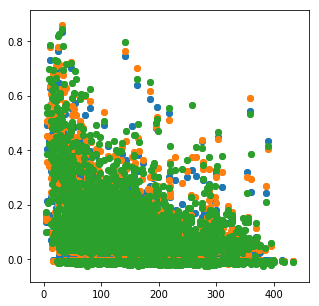

In [8]:
combined_df_5_6 = bin_correlation_rel_dist(results.cnmfe_results['C'],5,6,coordinates)[0]
combined_df_10_6 = bin_correlation_rel_dist(results.cnmfe_results['C'],10,6,coordinates)[0]
combined_df_20_6 = bin_correlation_rel_dist(results.cnmfe_results['C'],20,6,coordinates)[0]

In [ ]:
combined_df_5_6.to_csv(r'C:\Users\Santiago PC\Documents\miniscope_data\GRIN_outputs\out\28-Feb_16_21_21\combined_dfs\combined_df_5_6')
combined_df_10_6.to_csv(r'C:\Users\Santiago PC\Documents\miniscope_data\GRIN_outputs\out\28-Feb_16_21_21\combined_dfs\combined_df_10_6')
combined_df_20_6.to_csv(r'C:\Users\Santiago PC\Documents\miniscope_data\GRIN_outputs\out\28-Feb_16_21_21\combined_dfs\combined_df_20_6')

In [ ]:
plt.scatter(combined_df_5_6["rel_dist"],combined_df_5_6["corrcoef"])
plt.scatter(combined_df_10_6["rel_dist"],combined_df_10_6["corrcoef"])
plt.scatter(combined_df_20_6["rel_dist"],combined_df_20_6["corrcoef"])
plt.ylabel('Correlation Coefficient')
plt.xlabel('Relative Distance in pixels')